In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import rasterio as rio
import rasterstats 
from rasterio.plot import show
import os
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
import seaborn as sns
from geopy.distance import geodesic

In [43]:
# reading shape files and mapping the route 
def read_shape(shapefile, route):
    fp = shapefile
    dat = gpd.read_file(fp)
    da = dat[dat['ROUTE_NUM'] == route]
    
    # da.to_file("da.shp")
    # points = folium.GeoJson(da.to_json())
    # map = folium.Map(location = [47.6, -122.3], zoom_start = 12).add_child(points)
    
    return(da)
    
# reading raster files and extract elevation 
def extract_elev(shapefile, route, rasterfile):
    da = read_shape(shapefile, route)
    raw_elev = pd.DataFrame(rasterstats.gen_point_query(da, rasterfile))
    elev = [x for x in raw_elev.iloc[0,:] if x is not None] 
    print('The number of points: {}' .format(len(elev)))
    elev_meter = np.array(elev) * 0.3048
    return(elev_meter)


# extracting points from linestring 
def extract_point(shapefile, route):
    da = read_shape(shapefile, route)
    geoms = [mapping(da.geometry.values[0])]
    ge = np.array(geoms[0]['coordinates'])[:,[0,1]]

    coord = []
    for i in range(len(ge)):
            coord.append([ge[i][1], ge[i][0]])

    return(coord)


# map points 
def map_point(shapefile, route):
    coord = extract_point(shapefile, route)
    loca = pd.DataFrame(np.array(coord)).values.tolist()

    map = folium.Map(location=[47.6, -122.3], zoom_start=12)
    for point in range(0, len(loca)):
        folium.Marker(loca[point]).add_to(map)
    
    return(map)


# distance measure 
def dist_measure(shapefile, route):
    coord = extract_point(shapefile, route)
    dis = []
    for i in range(len(coord)-1):
        dis.append(geodesic(coord[i],coord[i+1]).m)

    dist = np.insert(np.cumsum(dis), 0, 0)
    
    return(dis, dist)

def gradient(shapefile, route, rasterfile):
    dis, dist = dist_measure(shapefile, route)
    elev = extract_elev(shapefile, route, rasterfile)
    stress = np.insert(abs(np.diff(elev)/ dis), 0, 0)
    
    return(dis, dist, elev, stress)

def ss(shapefile, route, rasterfile):
    dis, dist, elev, stress = gradient(shapefile, route, rasterfile)
    s1 = 100* sum(stress)/ max(dist) 
    s2 = 100* sum(abs(np.diff(elev)))/ max(dist)
    s3 = 100* sum(np.insert(np.diff(elev)/ dis, 0, 0)[np.insert(np.diff(elev)/ dis, 0, 0) > 0])/ max(dist)
    s4 = 100* sum(np.insert(np.diff(elev)/ dis, 0, 0)[np.insert(np.diff(elev)/ dis, 0, 0) < 0])/ max(dist)
    
    print('Normalized stress: {}\n Differentiated stress: {}\n +stress: {} \n -stress: {}' 
          .format(s1, s2, s3, s4))
    
    return(s1, s2, s3, s4)

# route plots 
def profile_plot(shapefile, route, rasterfile):
    
    dis, dist, elev, stress = gradient(shapefile, route, rasterfile)
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    
    ax[0].plot(dist, elev, label= 'elevation', color='b', linewidth=4)
    ax[0].set_ylabel('Elevation (meter)', color='b')
    ax[0].tick_params('y', colors='b')
    ax[0].legend()
    ax[0].grid()
    
    # ax[1] = ax.twinx()
    ax[1].plot(dist, stress, label= 'stress index', color='r')
    ax[1].set_xlabel('Plain distance (meter)')
    ax[1].set_ylabel('Stress index', color='r')
    ax[1].tick_params('y', colors='r')
    ax[1].legend()
    ax[1].grid()
    
    return

The number of points: 268


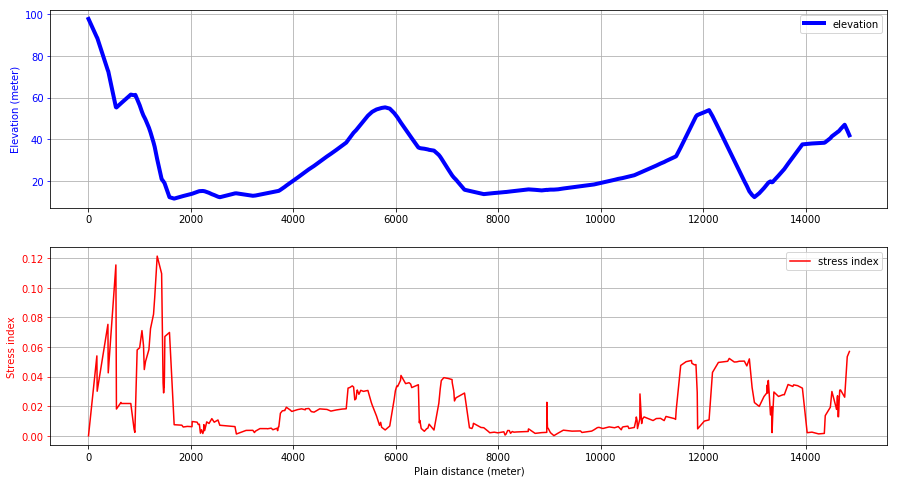

In [19]:
profile_plot('six_routes.shp', 7, 'seattle_dtm.tif')

The number of points: 333


The number of points: 221


The number of points: 208


The number of points: 268


The number of points: 352


The number of points: 529




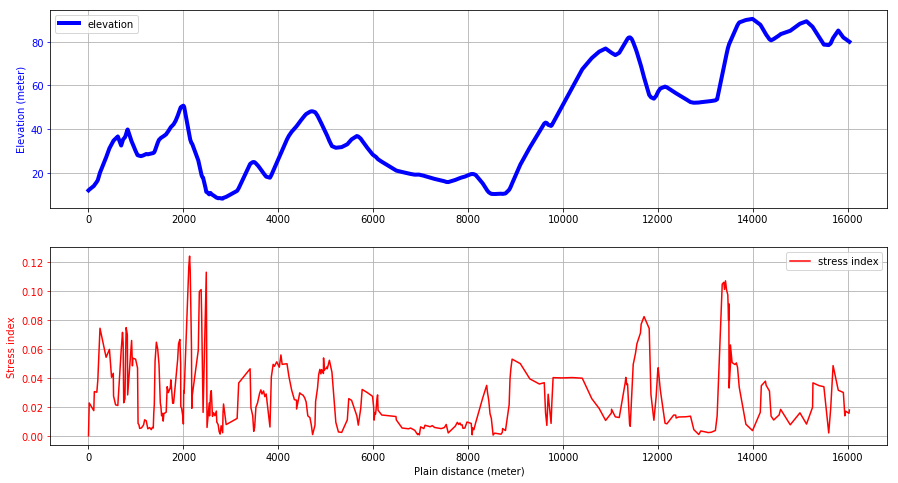

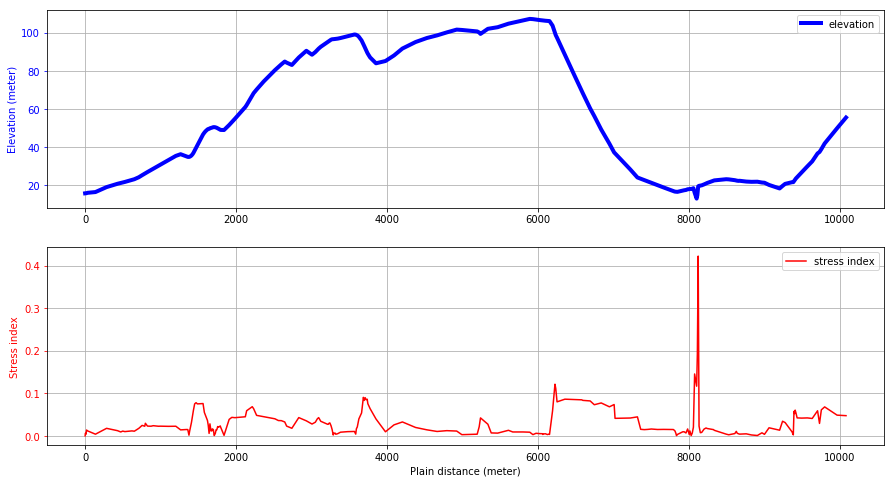

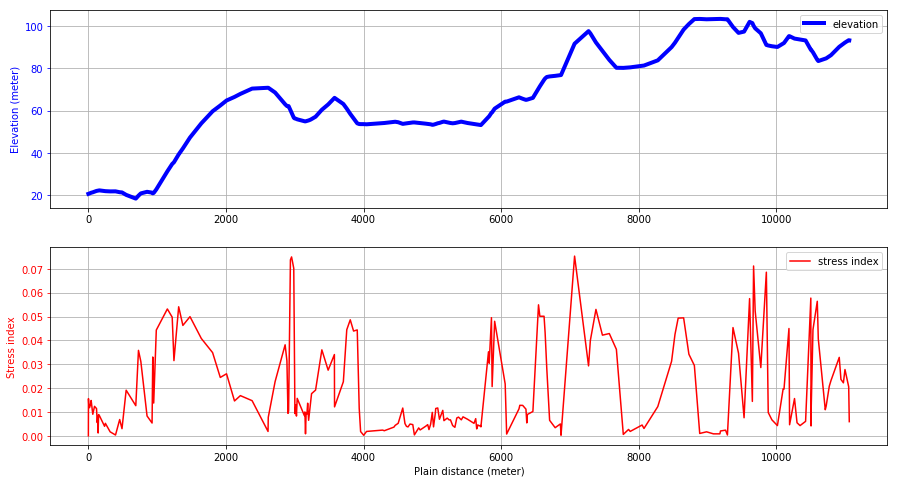

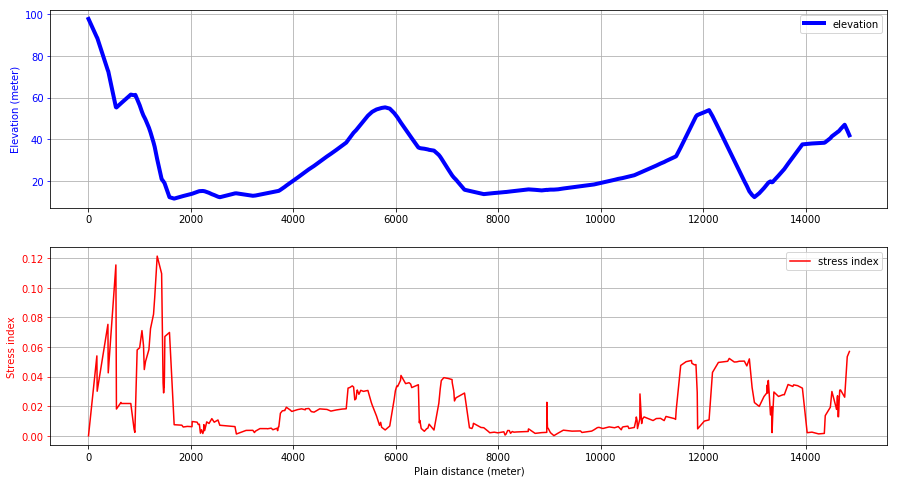

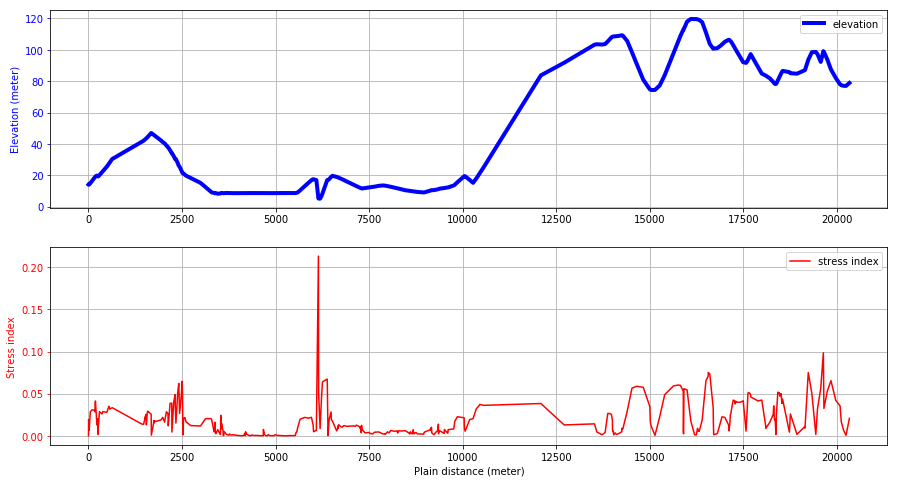

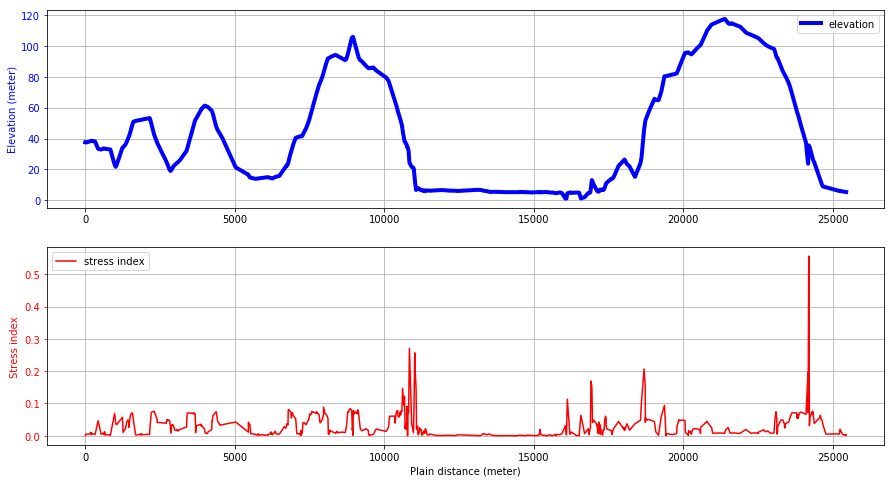

In [20]:
list = [75, 48, 45, 7, 40, 50]
for i in list:
    profile_plot('six_routes.shp', i, 'seattle_dtm.tif')
    print('\n')


In [44]:
bus_num = [75, 48, 45, 7, 40, 50]
num = len(bus_num)
s1 = [0]*num
s2 = [0]*num
s3 = [0]*num
s4 = [0]*num
for i in range(num):
    s1[i], s2[i], s3[i], s4[i] = ss('six_routes.shp', bus_num[i], 'seattle_dtm.tif')
    print('\n')
    
data = pd.DataFrame({'Num': bus_num, 'S1': s1, 'S2': s2, 'S3': s3, 'S4': s4})

The number of points: 333
Normalized stress: 0.06029927213639709
 Differentiated stress: 2.672614037531775
 +stress: 0.03315722266852587 
 -stress: -0.027142049467871174


The number of points: 221
Normalized stress: 0.06851640551856875
 Differentiated stress: 2.879609238091266
 +stress: 0.03956496997763635 
 -stress: -0.028951435540932408


The number of points: 208
Normalized stress: 0.035814486267449805
 Differentiated stress: 2.229071386816903
 +stress: 0.02036244233115485 
 -stress: -0.015452043936294938


The number of points: 268
Normalized stress: 0.038339086980729666
 Differentiated stress: 2.1317523802947913
 +stress: 0.017157976257050792 
 -stress: -0.02118111072367887


The number of points: 352
Normalized stress: 0.03298497802659699
 Differentiated stress: 2.1674668871738114
 +stress: 0.016947067372290774 
 -stress: -0.016037910654306205


The number of points: 529
Normalized stress: 0.06840358301711075
 Differentiated stress: 2.745585460014406
 +stress: 0.0332689786747608

In [45]:
data

,Num,S1,S2,S3,S4
0,75,0.060299,2.672614,0.033157,-0.027142
1,48,0.068516,2.879609,0.039565,-0.028951
2,45,0.035814,2.229071,0.020362,-0.015452
3,7,0.038339,2.131752,0.017158,-0.021181
4,40,0.032985,2.167467,0.016947,-0.016038
5,50,0.068404,2.745585,0.033269,-0.035135
